<a href="https://colab.research.google.com/github/KeunhoLee/LeagueOfLegend/blob/master/DCGAN_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
tf.keras.backend.clear_session()

NameError: ignored

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.4.1'

In [4]:
import os.path
import numpy as np
from keras.models import * 
from keras.layers import * 
from keras.optimizers import * 
import keras.backend as K 
import matplotlib.pyplot as plt

import os 
from PIL import Image


In [5]:
K.set_image_data_format('channels_last')

In [6]:
class Gan: 
  def __init__(self, img_data): 
    img_size = img_data.shape[1]
    img_size_2 = img_data.shape[2]
    channel = img_data.shape[3] if len(img_data.shape) >= 4 else 1 
    self.img_data = img_data 
    self.input_shape = (img_size, img_size_2, channel) 
    self.img_rows = img_size 
    self.img_cols = img_size_2 
    self.channel = channel 
    self.noise_size = 100 
    
    # Create D and G. 
    self.create_d() 
    self.create_g() 
    
    # Build model to train D. 
    optimizer = Adam(lr=0.0008) 
    self.D.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # Build model to train G. 
    optimizer = Adam(lr=0.0004) 
    self.D.trainable = False
    self.AM = Sequential() 
    self.AM.add(self.G) 
    self.AM.add(self.D) 
    self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)

  def create_d(self):
    self.D = Sequential()
    depth = 64
    dropout = 0.4 
    self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Conv2D(depth*2, 5, strides=2, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Conv2D(depth*4, 5, strides=2, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Conv2D(depth*8, 5, strides=1, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Flatten()) 
    self.D.add(Dense(1)) 
    self.D.add(Activation('sigmoid')) 
    self.D.summary() 
    return self.D

  def create_g(self):
    self.G = Sequential()
    dropout = 0.4
    depth = 64+64+64+64
    dim = 8 
    self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size)) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(Reshape((dim, dim, depth))) 
    self.G.add(Dropout(dropout)) 
    self.G.add(UpSampling2D()) 
    self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(UpSampling2D()) 
    self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(Conv2DTranspose(self.channel, 5, padding='same')) 
    self.G.add(Activation('sigmoid')) 
    self.G.summary() 
    return self.G
  
  def train(self, batch_size=100):   
    # Pick image data randomly. 
    
    images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :] 
    
    # Generate images from noise. 
    
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
    images_fake = self.G.predict(noise) 
    
    # Train D. 
    x = np.concatenate((images_train, images_fake)) 
    y = np.ones([2*batch_size, 1]) 
    y[batch_size:, :] = 0 
    self.D.trainable = True 
    d_loss = self.D.train_on_batch(x, y) 
    
    # Train G. 
    y = np.ones([batch_size, 1]) 
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
    self.D.trainable = False 
    a_loss = self.AM.train_on_batch(noise, y) 
    
    return d_loss, a_loss, images_fake

  def predict(self, noise):
    return self.G.predict(noise)

  def save(self):
    self.G.save_weights('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_g_weights.h5') 
    self.D.save_weights('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_d_weights.h5')

  def load(self):
    if os.path.isfile('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_g_weights.h5'):
      self.G.load_weights('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_g_weights.h5') 
      print("Load G from file.") 

    if os.path.isfile('gan_d_weights.h5'): 
      self.D.load_weights('gan_d_weights.h5') 
      print("Load D from file.")

class NaverData(): 
  def __init__(self): 
    img_data_list = [] 
    err_cnt1=0
    err_cnt2=0
    images = os.listdir("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails_resize") #naver_id_" + str(id) + ".jpg
    for i, path in enumerate(images): 

      title, ext = os.path.splitext(path)
      if ext not in ['.jpg']:
        continue
      
      try:
        img = Image.open("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails_resize/" + path) 
      except:
        err_cnt1+=1
       
      if np.array(img).shape != (32,32,3):
        err_cnt2 += 1
        continue
      
      img_data_list.append([np.array(img).astype('float32')]) 
      # print(np.array(img).shape)
      
    try:
      self.x_train = np.vstack(img_data_list) / 255.0 
    except ValueError as e:
      err_cnt2 += 1 
      print(path + " Error : ", e)
    # print(self.x_train.shape)
    print(err_cnt1, "error occured.")
    print(err_cnt2, "error occured.")


In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [72]:
# import os 
# from PIL import Image 
# images = os.listdir("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails") 
# err_cnt = 0

# for i, name in enumerate(images): 
#   # print(i)
#   try:
#     img = Image.open("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails/" + name)
#     img_resize = img.resize((32, 32), Image.ANTIALIAS)
#     img_resize.save(f'/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails_resize/naver_id_{i}.jpg')
#   except:
#     err_cnt += 1

In [9]:
dataset = NaverData()

47 error occured.
4 error occured.


In [15]:
import pickle

with open('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/data_32_32.pickle', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

In [10]:
# Load dataset.
# dataset = PokemonData() 
x_train = dataset.x_train 

In [11]:
x_train.shape

(1256, 32, 32, 3)

In [12]:
# Init network 

gan = Gan(x_train) 
# gan.load()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         8

Epoch: 0, D Loss: 0.4629279659129679, AM Loss: 0.2681393965808146
Epoch: 20, D Loss: 0.2591882397731145, AM Loss: 3.1138756275177
Epoch: 40, D Loss: 0.05727387204145392, AM Loss: 4.798912187417348
Epoch: 60, D Loss: 0.27492974574367207, AM Loss: 3.6922578116257987
Epoch: 80, D Loss: 0.3901420757174492, AM Loss: 3.790717755754789
Epoch: 100, D Loss: 0.10620941547676921, AM Loss: 4.61210435628891
Epoch: 120, D Loss: 0.2012611081202825, AM Loss: 2.5103812217712402
Epoch: 140, D Loss: 0.2717758392294248, AM Loss: 2.2442337572574615
Epoch: 160, D Loss: 0.19518976286053658, AM Loss: 3.6271427075068154
Epoch: 180, D Loss: 0.30851251011093456, AM Loss: 2.0819031099478402
Epoch: 200, D Loss: 0.4278235820432504, AM Loss: 2.7409659226735434
Epoch: 220, D Loss: 0.21145356570680937, AM Loss: 2.4886115193367004
Epoch: 240, D Loss: 0.29656703397631645, AM Loss: 2.748589555422465
Epoch: 260, D Loss: 0.30658958852291107, AM Loss: 3.55352516969045
Epoch: 280, D Loss: 0.25669020414352417, AM Loss: 1.6524

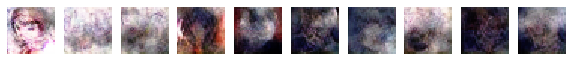

In [16]:
# Some parameters. 
epochs = 5000 
sample_size = 10 
batch_size = 100
train_per_epoch = x_train.shape[0] // batch_size
gen_imgs = []

for epoch in range(0, epochs): 
  total_d_loss = 0.0 
  total_a_loss = 0.0 
  imgs = None 
  
  for batch in range(0, train_per_epoch): 
    d_loss, a_loss, t_imgs = gan.train(batch_size) 
    total_d_loss += d_loss 
    total_a_loss += a_loss 
    
    if imgs is None:
      imgs = t_imgs
  gen_imgs.append(imgs)

  if epoch % 20 == 0 or epoch == epochs - 1: 
    total_d_loss /= train_per_epoch 
    total_a_loss /= train_per_epoch 
    print("Epoch: {}, D Loss: {}, AM Loss: {}" .format(epoch, total_d_loss, total_a_loss))

# Show generated images. 

fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1)) 
for i in range(0, sample_size): 
  ax[i].set_axis_off() 
  ax[i].imshow(imgs[i].reshape((gan.img_rows, gan.img_cols, gan.channel)), interpolation='nearest'); 
plt.show() 
plt.close(fig); 
  
# Save weights 
gan.save()

In [17]:
gan.G.save_weights("./gan_g_weights.h5")

In [18]:
gan.D.save_weights("./gan_d_weights.h5")

In [19]:
! cp gan_d_weights.h5 ./gdrive/MyDrive/saap_pjt_1_thumbnail/weights/
! cp gan_g_weights.h5 ./gdrive/MyDrive/saap_pjt_1_thumbnail/weights/

In [ ]:
with open('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/gen_images_3232.pickle', 'wb') as f:
    pickle.dump(gen_imgs, f, pickle.HIGHEST_PROTOCOL)

In [1]:
imgs

NameError: ignored

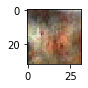

In [155]:
fake_img = gan.predict(np.random.uniform(-1.0, 1.0, size=[1, 100]) )

fig, ax = plt.subplots(1, 1, figsize=(1, 1)) 
ax.imshow(fake_img.reshape((gan.img_rows, gan.img_cols, gan.channel)), interpolation='nearest'); 
plt.show()
plt.close(fig); 